# Spatial regression

> **NOTE**: some of this material has been ported and adapted from the PySAL/spreg code for Chapter 5-13 in *Modern Spatial Econometrics in Practice: A Guide to GeoDa, GeoDaSpace and PySAL* by Luc Anselin and Sergio J. Rey. (c) 2014 Luc Anselin and Sergio J. Rey, All Rights Reserved.

* [Basic OLS](#Basic-OLS)
    * Nonspatial diagnostics
    * Spatial diagnostics - spatial specification
* [Spatial Lag Model](#Spatial-Lag-Model)
    * Spatial two Stage Least Squares (S2SLS)
        * Spatial diagnostics
        * Interpretation
            * Direct impact
            * Indirect impact
* [Spatial Model with Lag and Error](#Spatial-Model-with-Lag-and-Error)
    
* [Spatial error model](#Spatial-Error-Model)

## Basic Regression Setup##

**Creating arrays for y and x using the Baltimore house price example**

Preliminaries, importing **numpy** and **PySAL**

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pysal as ps

Loading the data set **baltim.dbf** from pysal exmaple datasets and creating the data object.

In [3]:
db = ps.open(ps.examples.get_path("baltim.dbf"),'r')
db.header

[u'STATION',
 u'PRICE',
 u'NROOM',
 u'DWELL',
 u'NBATH',
 u'PATIO',
 u'FIREPL',
 u'AC',
 u'BMENT',
 u'NSTOR',
 u'GAR',
 u'AGE',
 u'CITCOU',
 u'LOTSZ',
 u'SQFT',
 u'X',
 u'Y']

Check how many observations:

In [4]:
len(db)

211

**y** - dependent variable is PRICE

In [5]:
y_name = "PRICE"

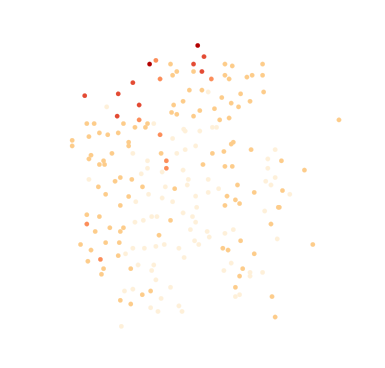

In [6]:
from pysal.contrib.viz import mapping as maps
db_pd = ps.pdio.read_files(ps.examples.get_path("baltim.shp"))
fig, ax = plt.subplots(1, figsize=(6, 6))
maps.geoplot(db_pd, y_name,ax=ax, palette='OrRd',classi="Equal_Interval")

Create the y array as a n by 1 column vector (hence the transpose **T**)

In [7]:
y = np.array([db.by_col(y_name)]).T

Check on the dimensions

In [8]:
y.shape

(211, 1)

**x** - the explanatory variables

First create a list with the variable names, then use a list comprehension to create the **x** array

In [9]:
x_names = ['NROOM','NBATH','PATIO','FIREPL','AC','GAR','AGE',
           'LOTSZ','SQFT']
x = np.array([db.by_col(var) for var in x_names]).T

Check on dimensions

In [10]:
x.shape

(211, 9)

**Model weights** - needed for spatial diagnostics

k nearest neighbor with k=4 constructed from **baltim.shp**, using STATION as the ID variable

In [11]:
w = ps.knnW_from_shapefile(ps.examples.get_path('baltim.shp'),k=4,idVariable='STATION')

Quick check on dimension

In [12]:
w.n

211

In [13]:
w.histogram

[(4, 211)]

row-standardize - is **always** necessary

In [14]:
w.transform = 'r'

Quick check on the values of the weights

In [15]:
w.weights[1]

[0.25, 0.25, 0.25, 0.25]

## Basic OLS 

**OLS with variable and data set names**

$$\mathbf{y}=\mathbf{X} \beta + \mathbf{\epsilon}$$

In [16]:
ols1a = ps.spreg.OLS(y,x,name_y=y_name,name_x=x_names, name_ds='baltim.shp')

In [17]:
print ols1a.summary

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :  baltim.shp
Weights matrix      :        None
Dependent Variable  :       PRICE                Number of Observations:         211
Mean dependent var  :     44.3072                Number of Variables   :          10
S.D. dependent var  :     23.6061                Degrees of Freedom    :         201
R-squared           :      0.6500
Adjusted R-squared  :      0.6343
Sum squared residual:   40960.463                F-statistic           :     41.4718
Sigma-square        :     203.783                Prob(F-statistic)     :    3.24e-41
S.E. of regression  :      14.275                Log likelihood        :    -855.223
Sigma-square ML     :     194.125                Akaike info criterion :    1730.446
S.E of regression ML:     13.9329                Schwarz criterion     :    1763.965

-----------------------------------------------------------------------------

## OLS with White Test

set **white_test = True**

In [18]:
ols2 = ps.spreg.OLS(y,x,white_test=True,name_y=y_name,name_x=x_names,name_ds='baltim.shp')

In [19]:
print ols2.summary

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :  baltim.shp
Weights matrix      :        None
Dependent Variable  :       PRICE                Number of Observations:         211
Mean dependent var  :     44.3072                Number of Variables   :          10
S.D. dependent var  :     23.6061                Degrees of Freedom    :         201
R-squared           :      0.6500
Adjusted R-squared  :      0.6343
Sum squared residual:   40960.463                F-statistic           :     41.4718
Sigma-square        :     203.783                Prob(F-statistic)     :    3.24e-41
S.E. of regression  :      14.275                Log likelihood        :    -855.223
Sigma-square ML     :     194.125                Akaike info criterion :    1730.446
S.E of regression ML:     13.9329                Schwarz criterion     :    1763.965

-----------------------------------------------------------------------------

now the **White** test is included as one of the diagnostics

## OLS with Spatial Diagnostics

specify the weights (**w**) and set **spat_diag = True** and **moran = True**

specify a name for the weights in **name_w**, all the rest is as before

for convenience, white_test is back to default of False

In [20]:
ols3 = ps.spreg.OLS(y,x,w=w,spat_diag=True,moran=True,
                       name_y=y_name,name_x=x_names,name_w='baltim_k4',
                       name_ds='baltim.shp')

In [21]:
print ols3.summary

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :  baltim.shp
Weights matrix      :   baltim_k4
Dependent Variable  :       PRICE                Number of Observations:         211
Mean dependent var  :     44.3072                Number of Variables   :          10
S.D. dependent var  :     23.6061                Degrees of Freedom    :         201
R-squared           :      0.6500
Adjusted R-squared  :      0.6343
Sum squared residual:   40960.463                F-statistic           :     41.4718
Sigma-square        :     203.783                Prob(F-statistic)     :    3.24e-41
S.E. of regression  :      14.275                Log likelihood        :    -855.223
Sigma-square ML     :     194.125                Akaike info criterion :    1730.446
S.E of regression ML:     13.9329                Schwarz criterion     :    1763.965

-----------------------------------------------------------------------------

diagnostics for spatial dependence at the bottom of the listing

Pointing to a spatial lag or a SARMA specification? Let's run both of them

## Spatial Lag Model
$$\mathbf{y}= \rho \mathbf{Wy} + \mathbf{X} \beta + \mathbf{\epsilon}$$

### Spatial two Stage Least Squares (S2SLS)

The endogeneity of the lagged dependent variable $\mathbf{Wy}$ can be dealt with by using instrumental variables $[\mathbf{X}, \mathbf{WX}, \mathbf{W^2X}]$.

The default setting of instrumental variables in PySAL `GM_Lag` includes exogeneous variables and their first-oder spatial lags $[\mathbf{X}, \mathbf{WX}]$.

In [22]:
S2SLS1 = ps.spreg.GM_Lag(y,x,w=w,name_y=y_name,name_x=x_names,name_w='baltim_k4',name_ds='baltim')

In [23]:
print S2SLS1.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :      baltim
Weights matrix      :   baltim_k4
Dependent Variable  :       PRICE                Number of Observations:         211
Mean dependent var  :     44.3072                Number of Variables   :          11
S.D. dependent var  :     23.6061                Degrees of Freedom    :         200
Pseudo R-squared    :      0.7083
Spatial Pseudo R-squared:  0.6820

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.0625980       5.8254085      -0.0107457       0.9914263
               NROOM       1.0193546       1.1007833       0.9260266       0.3544322
               NBATH       5.5644252       1.7986364       

#### including spatial diagnostics, set `spat_diag=True`

In [24]:
S2SLS1_sp = ps.spreg.GM_Lag(y,x,w=w,spat_diag=True,
                          name_y=y_name,name_x=x_names,
                          name_w='baltim_k4',name_ds='baltim')
print S2SLS1_sp.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :      baltim
Weights matrix      :   baltim_k4
Dependent Variable  :       PRICE                Number of Observations:         211
Mean dependent var  :     44.3072                Number of Variables   :          11
S.D. dependent var  :     23.6061                Degrees of Freedom    :         200
Pseudo R-squared    :      0.7083
Spatial Pseudo R-squared:  0.6820

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.0625980       5.8254085      -0.0107457       0.9914263
               NROOM       1.0193546       1.1007833       0.9260266       0.3544322
               NBATH       5.5644252       1.7986364       

### Direct & Indirect Impacts

In [25]:
b = S2SLS1_sp.betas[:-1]
b

array([[-0.062598  ],
       [ 1.01935457],
       [ 5.5644252 ],
       [ 7.07238883],
       [ 7.30516192],
       [ 6.12992825],
       [ 3.41029693],
       [-0.09081007],
       [ 0.06599566],
       [ 0.06279926]])

In [26]:
rho = S2SLS1_sp.betas[-1]
rho

array([ 0.50431292])

In [27]:
btot = b / (1.0 - rho) #direct impact
bind = btot - b #indirect impact

In [28]:
varnames = ["CONSTANT"] + x_names
print "Variable       Direct       Indirect      Total"
for i in range(len(varnames)):
    print("%10s %12.7f %12.7f %12.7f" % (varnames[i],b[i][0],bind[i][0],btot[i][0]))

Variable       Direct       Indirect      Total
  CONSTANT   -0.0625980   -0.0636873   -0.1262853
     NROOM    1.0193546    1.0370932    2.0564477
     NBATH    5.5644252    5.6612562   11.2256814
     PATIO    7.0723888    7.1954611   14.2678500
    FIREPL    7.3051619    7.4322849   14.7374468
        AC    6.1299283    6.2366001   12.3665283
       GAR    3.4102969    3.4696422    6.8799392
       AGE   -0.0908101   -0.0923903   -0.1832004
     LOTSZ    0.0659957    0.0671441    0.1331398
      SQFT    0.0627993    0.0638921    0.1266913


#### using second order spatial lags for the instruments, set `w_lags = 2`

In [29]:
S2SLS2_sp = ps.spreg.GM_Lag(y,x,w=w,w_lags=2,spat_diag=True,
                          name_y=y_name,name_x=x_names,
                          name_w='baltim_k4',name_ds='baltim')
print S2SLS2_sp.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :      baltim
Weights matrix      :   baltim_k4
Dependent Variable  :       PRICE                Number of Observations:         211
Mean dependent var  :     44.3072                Number of Variables   :          11
S.D. dependent var  :     23.6061                Degrees of Freedom    :         200
Pseudo R-squared    :      0.7080
Spatial Pseudo R-squared:  0.6808

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.4328107       5.7762571      -0.0749293       0.9402710
               NROOM       1.0319982       1.1011225       0.9372238       0.3486435
               NBATH       5.5630927       1.7997173       

## Spatial Model with Lag and Error
Or SAR-SAR

$$\mathbf{y}= \rho \mathbf{Wy} + \mathbf{X} \beta + \mathbf{\mu}$$
$$\mathbf{\mu} = \lambda \mathbf{W \mu} + \mathbf{\epsilon}$$

In [30]:
ps.spreg.GM_Combo?

In [31]:
combo1 = ps.spreg.GM_Combo(y,x,w=w,name_y=y_name,
                       name_x=x_names,name_w="baltim_k4",
                       name_ds="baltim")
print combo1.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES
-------------------------------------------------------------
Data set            :      baltim
Weights matrix      :   baltim_k4
Dependent Variable  :       PRICE                Number of Observations:         211
Mean dependent var  :     44.3072                Number of Variables   :          11
S.D. dependent var  :     23.6061                Degrees of Freedom    :         200
Pseudo R-squared    :      0.7055
Spatial Pseudo R-squared:  0.6929

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       4.1878228       5.3374979       0.7846041       0.4326857
               NROOM       0.3653342       1.0758344       0.3395822       0.7341712
               NBATH       4.4258374 

## Spatial Error Model

$$\mathbf{y}= \mathbf{X} \beta + \mathbf{\mu}$$
$$\mathbf{\mu} = \lambda \mathbf{W \mu} + \mathbf{\epsilon}$$

In [32]:
sem = ps.spreg.GM_Error(y,x,w=w,name_y=y_name,
                       name_x=x_names,name_w="baltim_k4",
                       name_ds="baltim")
print sem.summary

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES
---------------------------------------------------
Data set            :      baltim
Weights matrix      :   baltim_k4
Dependent Variable  :       PRICE                Number of Observations:         211
Mean dependent var  :     44.3072                Number of Variables   :          10
S.D. dependent var  :     23.6061                Degrees of Freedom    :         201
Pseudo R-squared    :      0.6489

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      21.6103217       5.0951325       4.2413660       0.0000222
               NROOM       0.6898973       1.1618343       0.5938001       0.5526459
               NBATH       6.0370628       1.9602958       3.0796693       0.0020723
      

## Practice##

Create a regression object using the classic Harrison-Rubinfeld Boston house price data set (included as Boston.shp). Regression median house value (MEDV) on crime rate (CRIM), Charles river dummy (CHAS), nitric oxides (NOX), number of rooms (RM), age (AGE), weighted distance to five employment centers (DIS) and percent "lower status population" (LSTAT). A full description of the Boston data set is available on the GeoDa Center sample data set site.

Use a k-nearest neighbor spatial weights (k = 4) for the spatial diagnostics.

What is the most likely alternative spatial regression model, given the results of a spatial specification search.

Try any other combinations of explanatory variables, spatial weights and standard error specifications.

## Solutions

In [33]:
db = ps.open("data/Boston.dbf",'r')
db.header

[u'POLY_ID',
 u'ID',
 u'TOWN',
 u'TOWNNO',
 u'TRACT',
 u'LON',
 u'LAT',
 u'x',
 u'y',
 u'MEDV',
 u'CMEDV',
 u'CRIM',
 u'ZN',
 u'INDUS',
 u'CHAS',
 u'NOX',
 u'RM',
 u'AGE',
 u'DIS',
 u'RAD',
 u'TAX',
 u'PTRATIO',
 u'B',
 u'LSTAT']

In [34]:
y_name = "MEDV"
y = np.array([db.by_col(y_name)]).T

In [35]:
x_names = ["CRIM","CHAS","NOX","RM","AGE","DIS","LSTAT"]
x = np.array([db.by_col(var) for var in x_names]).T

In [36]:
w = ps.knnW_from_shapefile('data/Boston.shp',k=4)

In [37]:
ols1a = ps.spreg.OLS(y,x,w=w,spat_diag=True,moran=True, name_y=y_name,name_x=x_names, name_ds='Boston.shp')

In [38]:
print(ols1a.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :  Boston.shp
Weights matrix      :     unknown
Dependent Variable  :        MEDV                Number of Observations:         506
Mean dependent var  :     22.5328                Number of Variables   :           8
S.D. dependent var  :      9.1971                Degrees of Freedom    :         498
R-squared           :      0.6788
Adjusted R-squared  :      0.6743
Sum squared residual:   13719.651                F-statistic           :    150.3613
Sigma-square        :      27.550                Prob(F-statistic)     :  1.732e-118
S.E. of regression  :       5.249                Log likelihood        :   -1552.895
Sigma-square ML     :      27.114                Akaike info criterion :    3121.790
S.E of regression ML:      5.2071                Schwarz criterion     :    3155.602

-----------------------------------------------------------------------------

In [39]:
kw = ps.adaptive_kernelW_from_shapefile('data/Boston.shp',
                                             k=12,diagonal=True)

In [40]:
ols6 = ps.spreg.OLS(y,x,w=w,spat_diag=True,moran=True,robust='hac',gwk=kw,
                       name_y=y_name,name_x=x_names,
                       name_gwk='Boston_tri_k12',name_ds='Boston.shp')
print(ols6.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :  Boston.shp
Weights matrix      :     unknown
Dependent Variable  :        MEDV                Number of Observations:         506
Mean dependent var  :     22.5328                Number of Variables   :           8
S.D. dependent var  :      9.1971                Degrees of Freedom    :         498
R-squared           :      0.6788
Adjusted R-squared  :      0.6743
Sum squared residual:   13719.651                F-statistic           :    150.3613
Sigma-square        :      27.550                Prob(F-statistic)     :  1.732e-118
S.E. of regression  :       5.249                Log likelihood        :   -1552.895
Sigma-square ML     :      27.114                Akaike info criterion :    3121.790
S.E of regression ML:      5.2071                Schwarz criterion     :    3155.602

HAC Standard Errors; Kernel Weights: Boston_tri_k12
-------------------------